<a href="https://colab.research.google.com/github/tancik/fourier-feature-networks/blob/master/Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D image regression

In [ ]:
!pip install -q livelossplot

In [ ]:
import jax
from jax import random, grad, jit, vmap
from jax.config import config
import jax.numpy as np
from jax.experimental import optimizers, stax

from livelossplot import PlotLosses
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import os

import imageio

from tqdm.notebook import tqdm as tqdm

## Random seed
rand_key = random.PRNGKey(10)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


# Load Target Image

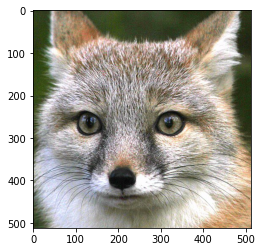

In [ ]:
RES = 512
image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/6/61/The_quick_brown_fox....._%2815677707699%29.jpg/1024px-The_quick_brown_fox....._%2815677707699%29.jpg'

im = imageio.imread(image_url)
im = im[im.shape[0]//2-RES//2:im.shape[0]//2+RES//2,im.shape[1]//2-RES//2:im.shape[1]//2+RES//2,:] / 255.

x1_t = np.linspace(0, 1, RES+1)[:-1]
x_all = np.stack(np.meshgrid(x1_t,x1_t), axis=-1)

x_train = x_all[::2,::2,:]
x_test = x_all[1::2,1::2,:]

im_train = im[::2,::2,:]
im_test = im[1::2,1::2,:]

plt.imshow(im)
plt.show()

# Model and training code

Our model is a coordinate-based multilayer perceptron. For each input image coordinate the model predicts the associated color.

![Network diagram](http://people.eecs.berkeley.edu/~tancik/ff/mlp_rotated.png)

In [ ]:
def make_network(num_layers, num_channels):
  layers = []
  for i in range(num_layers-1):
      layers.append(stax.Dense(num_channels))
      layers.append(stax.Relu)
  layers.append(stax.Dense(3))
  layers.append(stax.Sigmoid)
  return stax.serial(*layers)

model_loss = jit(lambda params, x, y: .5 * np.mean((apply_fn(params, x) - y) ** 2))
model_psnr = jit(lambda params, x, y: -10 * np.log10(2.*model_loss(params, x, y)))
model_grad_loss = jit(lambda params, x, y: jax.grad(model_loss)(params, x, y))

def input_encoder(x, b_vals):
    if b_vals is None:
        return x
    x = np.concatenate([np.sin((2.*np.pi*x) @ b_vals.T), np.cos((2.*np.pi*x) @ b_vals.T)], axis=-1)
    return x

def train_model(lr, iters, train_data, test_data, plot_groups, name='', ):
    opt_init, opt_update, get_params = optimizers.adam(lr)
    opt_update = jit(opt_update)

    _, params = init_fn(rand_key, (-1, train_data[0].shape[-1]))
    opt_state = opt_init(params)

    train_psnrs = []
    test_psnrs = []
    plot_groups['Test PSNR'].append(f'{name}_test')
    plot_groups['Train PSNR'].append(f'{name}_train')
    for i in tqdm(range(iters), desc='train iter', leave=False):
        opt_state = opt_update(i, model_grad_loss(get_params(opt_state), *train_data), opt_state)
        if i % 25 == 0:
            train_psnr = model_psnr(get_params(opt_state), *train_data)
            test_psnr = model_psnr(get_params(opt_state), *test_data)
            train_psnrs.append(train_psnr)
            test_psnrs.append(test_psnr)
            plotlosses_model.update({f'{name}_train':train_psnr, f'{name}_test':test_psnr}, current_step=i)
        if i % 100 == 0 and i != 0:
            plotlosses_model.send()
    plotlosses_model.send()
    results = {
        'state': get_params(opt_state),
        'train_psnrs': train_psnrs,
        'test_psnrs': test_psnrs,
    }
    return results

We are interested in comparing the following mappings, $\gamma (\mathbf{v})$

> No mapping: $\gamma(\mathbf{v})= \mathbf{v}$. 

> Basic mapping: $\gamma(\mathbf{v})=\left[ \cos(2 \pi \mathbf{v}),\sin(2 \pi \mathbf{v}) \right]^\mathrm{T}$. 

> Positional encoding: $\gamma(\mathbf{v})=\left[ \ldots, \cos(2 \pi \sigma^{j/m} \mathbf{v}),\sin(2 \pi \sigma^{j/m} \mathbf{v}), \ldots \right]^\mathrm{T}$ for $j = 0, \ldots, m-1$. 

> Gaussian Fourier feature mapping: $\gamma(\mathbf{v})= \left[ \cos(2 \pi \mathbf B \mathbf{v}), \sin(2 \pi \mathbf B \mathbf{v}) \right]^\mathrm{T}$, 
where each entry in $\mathbf B \in \mathbb R^{m \times d}$ is sampled from $\mathcal N(0,\sigma^2)$


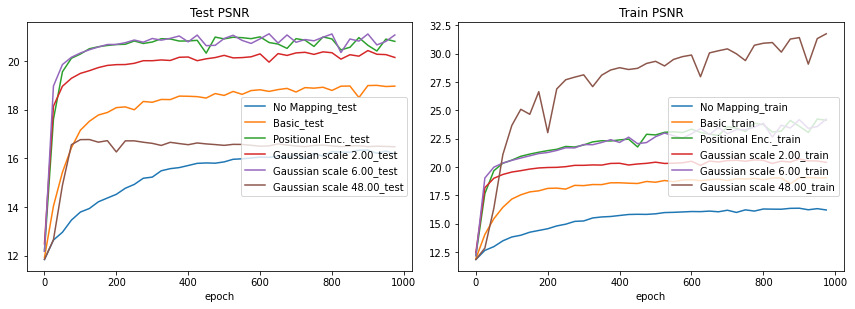

Test PSNR
	No Mapping_test  	 (min:   11.835, max:   16.342, cur:   16.183)
	Basic_test       	 (min:   11.915, max:   18.993, cur:   18.969)
	Positional Enc._test 	 (min:   12.192, max:   20.997, cur:   20.812)
	Gaussian scale 2.00_test 	 (min:   12.479, max:   20.433, cur:   20.150)
	Gaussian scale 6.00_test 	 (min:   12.173, max:   21.116, cur:   21.075)
	Gaussian scale 48.00_test 	 (min:   11.842, max:   16.768, cur:   16.475)
Train PSNR
	No Mapping_train 	 (min:   11.827, max:   16.356, cur:   16.201)
	Basic_train      	 (min:   11.906, max:   19.046, cur:   19.045)
	Positional Enc._train 	 (min:   12.180, max:   24.123, cur:   24.123)
	Gaussian scale 2.00_train 	 (min:   12.462, max:   20.699, cur:   20.407)
	Gaussian scale 6.00_train 	 (min:   12.157, max:   24.218, cur:   24.218)
	Gaussian scale 48.00_train 	 (min:   11.833, max:   31.755, cur:   31.755)


In [ ]:
#@markdown ##Network Params
network_depth =  4#@param
network_width = 256 #@param
lr =  1e-3#@param
training_steps =  1000#@param

#@markdown ##Mapping Params
embedding_size =  256#@param
posenc_scale =  5#@param
#@markdown gaussian_scales should be a list of scales (things like np.arange(...) allowed)
gaussian_scales = [2,6,48] #@param
#@markdown
include_no_mapping = True #@param {type:"boolean"}
include_basic = True #@param {type:"boolean"}
include_posenc = True #@param {type:"boolean"}
include_gaussian = True #@param {type:"boolean"}

init_fn, apply_fn = make_network(network_depth, network_width)

plt_groups = {'Test PSNR':[], 'Train PSNR':[]}
plotlosses_model = PlotLosses(groups=plt_groups)

bvals_dict = {}
outputs = {}

if include_no_mapping:
    bvals_dict['No Mapping'] = None

if include_basic:
    bvals_dict['Basic'] = np.eye(2)

if include_posenc:
    bvals = 2.**np.linspace(0,posenc_scale,embedding_size//2) - 1
    bvals = np.stack([bvals, np.zeros_like(bvals)], -1)
    bvals = np.concatenate([bvals, np.roll(bvals, 1, axis=-1)], 0) + 0
    bvals_dict['Positional Enc.'] = bvals

if include_gaussian:
    bvals = random.normal(rand_key, (embedding_size, 2))
    for scale in gaussian_scales:
        bvals_dict['Gaussian scale %.2f' % scale] = bvals * scale

for k in tqdm(bvals_dict, leave=False):
    train_data = (input_encoder(x_train, bvals_dict[k]), im_train)
    test_data = (input_encoder(x_test, bvals_dict[k]), im_test)
    outputs[k] = train_model(lr, training_steps, train_data, test_data, name=k, plot_groups=plt_groups)

# Visualize Results

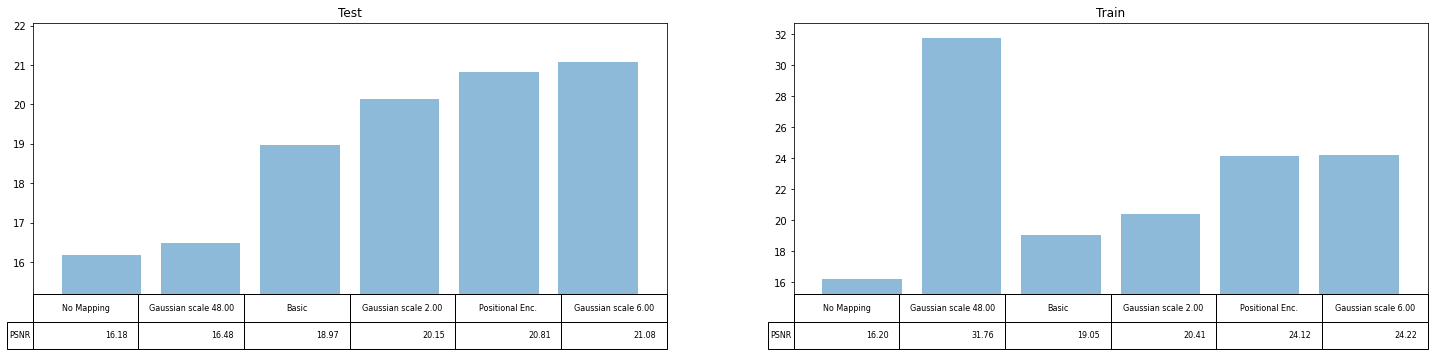

----------------------------------------
                  Test
----------------------------------------


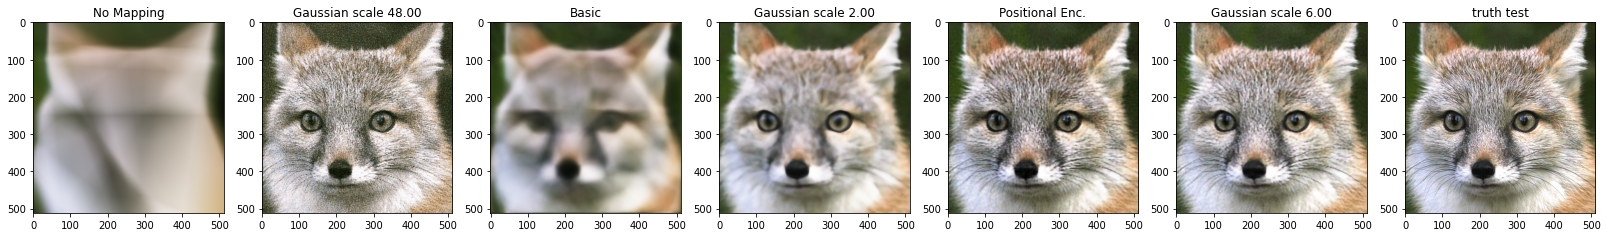

----------------------------------------
                  Train
----------------------------------------


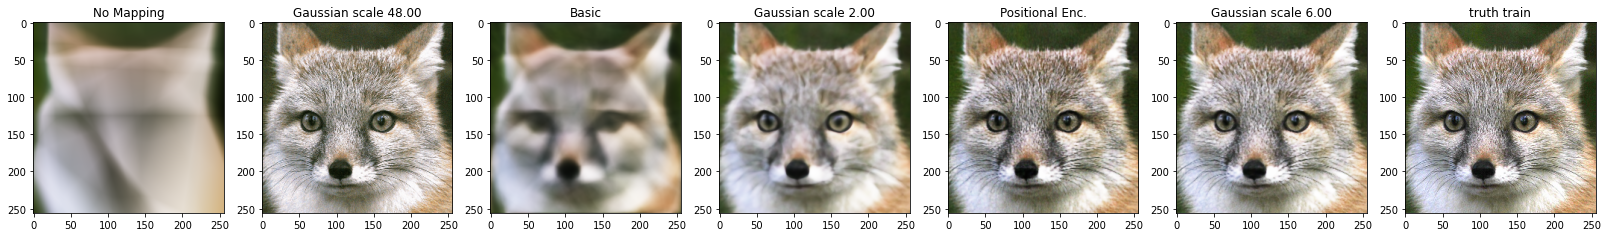

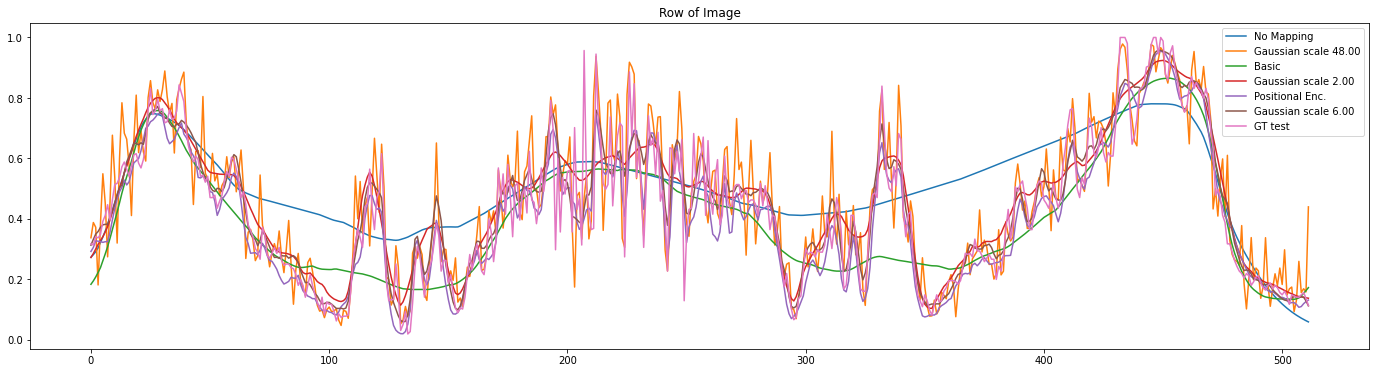

In [ ]:
#@title Plot Results

bar_graph = True #@param {type:"boolean"}
image_reconstructions = True #@param {type:"boolean"}
image_slice = True #@param {type:"boolean"}

names = list(outputs.keys())
xvals = np.arange(len(names))
test_values = np.array([outputs[n]['test_psnrs'][-1] for n in names])
test_values_mean = np.mean(test_values, axis=-1)
train_values = np.array([outputs[n]['train_psnrs'][-1] for n in names])
inds = np.argsort(test_values)
names_sort = [names[i] for i in inds]

if bar_graph:
    plt.figure(figsize=(25,5))
    plt.subplot(1,2,1)
    plt.bar(xvals, test_values[inds], color=colors[0], alpha=.5)
    plt.xticks([])
    plt.ylim(test_values.min()-1, test_values.max()+1)
    plt.title('Test')
    prnt_vals = ['%.2f' % x for x in test_values[inds]]
    plt.table(cellText=[prnt_vals],
        rowLabels=['PSNR'],
        colLabels= names_sort,
        loc='bottom',
        bbox=[0, -.2, 1, 0.2])

    plt.subplot(1,2,2)
    plt.bar(xvals, train_values[inds], color=colors[0], alpha=.5)
    plt.xticks([])
    plt.ylim(train_values.min()-1, train_values.max()+1)
    plt.title('Train')
    plt.table(cellText=[['%.2f' % x for x in train_values[inds].tolist()]],
        rowLabels=['PSNR'],
        colLabels=names_sort,
        loc='bottom',
        bbox=[0, -.2, 1, 0.2])
    
    plt.show()

if image_reconstructions:
    print('----------------------------------------')
    print('                  Test')
    print('----------------------------------------')
    plt.figure(figsize=(28,6))
    for i, p in enumerate(names_sort):
        pred = apply_fn(outputs[p]['state'], input_encoder(x_all, bvals_dict[p]))
        plt.subplot(1,len(names)+1,i+1)
        plt.imshow(pred)
        plt.title(p)

    plt.subplot(1,len(names)+1,len(names)+1)
    plt.imshow(im)
    plt.title('truth test')
    plt.show()

    print('----------------------------------------')
    print('                  Train')
    print('----------------------------------------')
    plt.figure(figsize=(28,6))
    for i, p in enumerate(names_sort):
        pred = apply_fn(outputs[p]['state'], input_encoder(x_train, bvals_dict[p]))
        plt.subplot(1,len(names)+1,i+1)
        plt.imshow(pred)
        plt.title(p)

    plt.subplot(1,len(names)+1,len(names)+1)
    plt.imshow(im_train)
    plt.title('truth train')
    plt.show()

if image_slice:
    plt.figure(figsize=(24,6))
    for i, p in enumerate(names_sort):
        pred = apply_fn(outputs[p]['state'], input_encoder(x_all, bvals_dict[p]))
        plt.plot(pred[pred.shape[0]//2,:,0], label=p)
    plt.plot(im[im.shape[0]//2,:,0], label='GT test')
    plt.legend()
    plt.title('Row of Image')
    plt.show()